In [1]:
import json 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
import glob

In [2]:
# Define the pattern for the files to find
pattern = 'paperFits/**/fit_stats_complete.json'

# Use glob to find all the files that match the pattern
file_paths = glob.glob(pattern, recursive=True)

# Initialize an empty list to store the data from the files
data = []

# Loop through the file paths
for file_path in file_paths:
    # Open each file
    with open(file_path, 'r') as file:
        # Load the JSON data from the file
        file_data = json.load(file)
        # Append the data to the list
        data.append(file_data)
print(len(data))

100


In [3]:
data

[{'lc_Bu2019lm_00710': {'0': {'nugent-hyper': {'luminosity_distance': 173.61329847933214,
     'timeshift': -0.9873689399796995,
     'supernova_mag_boost': -3.7785744419566902,
     'Ebv': 0.0,
     'log_likelihood': -2.341215993232556,
     'log_prior': -7.313220387090301,
     'log_bayes_factor': -4.277824332935942,
     'log_bayes_factor_err': 0.0381325573657601,
     'Best fit index': 2400,
     'Magnitudes': {'ztfg': [17.912174142773004,
       15.966796016971191,
       15.341164354847319,
       15.122447135891388,
       14.940488079566197,
       14.784691426283604,
       14.648470941140115,
       14.527451683043953,
       14.418578993059821],
      'bestfit_sample_times': [-0.8873689399796996,
       -0.38736893997969957,
       0.11263106002030054,
       0.6126310600203005,
       1.1126310600203007,
       1.6126310600203007,
       2.1126310600203007,
       2.6126310600203007,
       3.1126310600203]},
     'chi2_per_dof': 0.6285886879166032,
     'chi2_per_dof_per_f

In [15]:
## need to make it comprehensible
restructured_data = []

for observation in data:
    for obj, timesteps in observation.items():
        if obj == 'misc':  ## Skip "misc" since we don't really care about that
            continue
        for timestep, models in timesteps.items():
            for model, components in models.items():
                row = {'Object': obj, 'Timestep': int(timestep), 'Model': model}
                row.update(components)
                restructured_data.append(row)
df = pd.DataFrame(restructured_data)
display(df)


## forgot to include the reward in the output file, so need to calculate post-hoc. Uses same equation as in the MAB algo
rewards = []
for idx, row in df.iterrows():
    if row['Model'] == 'Bu2019lm':
        obj_df = df[df['Object'] == row['Object']]
        timestep_df = obj_df[obj_df['Timestep'] <= row['Timestep']]
        
        ## Select rows for the current timestep and object
        kn_row = timestep_df[timestep_df['Model'] == 'Bu2019lm'].iloc[0]
        other_models = timestep_df[timestep_df['Model'] != 'Bu2019lm']
        
        ## Calculate the difference in Bayes factors between the kilonova model and the next best model
        bf_kn = kn_row['log_likelihood']
        bf_non_kn = other_models['log_likelihood'].max()
        
        num_obs = len(obj_df[obj_df['Timestep'] <= row['Timestep']]) / obj_df['Model'].nunique() + 3 ## observed at least 3 times before timestep 0
        
        ## same equation as in the MAB algo
        reward = bf_kn - bf_non_kn + np.sqrt(2 * np.log(row['Timestep'] + 1) / num_obs)
    else:
        reward = np.nan  ## Reward for non-Bu2019lm models

    rewards.append(reward)

df['Reward'] = rewards
display(df)

Object  Timestep         Model  luminosity_distance  \
0         lc_Bu2019lm_00710         0  nugent-hyper           173.613298   
1         lc_Bu2019lm_00710         0      Bu2019lm             3.449449   
2         lc_Bu2019lm_00710         0      TrPi2018           170.616898   
3         lc_Bu2019lm_00710         1  nugent-hyper           219.069801   
4         lc_Bu2019lm_00710         1      Bu2019lm             3.998235   
...                     ...       ...           ...                  ...   
4792  lc_nugent-hyper_00275         0      Bu2019lm             9.173666   
4793  lc_nugent-hyper_00275         0      TrPi2018           165.255028   
4794  lc_nugent-hyper_00276         0  nugent-hyper           222.209848   
4795  lc_nugent-hyper_00276         0      Bu2019lm             3.702458   
4796  lc_nugent-hyper_00276         0      TrPi2018           180.923954   

      timeshift  supernova_mag_boost  Ebv  log_likelihood  log_prior  \
0     -0.987369            -3.778574  0.0       -2.341216  -7.313220   
1     -1.557894                  NaN  0.0       -1.838858 -12.193585   
2      0.595388                  NaN  0.0       -1.838739 -10.194626   
3     -0.978275            -4.067456  0.0       -3.428518  -7.313220   
4     -0.905437                  NaN  0.0       -2.761195 -12.145474   
...         ...                  ...  ...             ...        ...   
4792  -1.574642                  NaN  0.0       -2.120026 -12.044268   
4793   0.001210                  NaN  0.0       -1.839884  -9.985631   
4794  -0.943150            -4.169515  0.0       -1.838537  -7.313220   
4795  -1.800761                  NaN  0.0       -2.121490 -12.054834   
4796   0.683384                  NaN  0.0       -1.846191 -10.069360   

      log_bayes_factor  ...  log10_epsilon_B  log10_E0 thetaCore  thetaWing  \
0            -4.277824  ...              NaN       NaN       NaN        NaN   
1            -6.414408  ...              NaN       NaN       NaN        NaN   
2            -4.444133  ...        -2.663633      53.0      0.05        0.1   
3            -5.463299  ...              NaN       NaN       NaN        NaN   
4            -7.763889  ...              NaN       NaN       NaN        NaN   
...                ...  ...              ...       ...       ...        ...   
4792         -6.573756  ...              NaN       NaN       NaN        NaN   
4793         -4.594910  ...        -0.693933      53.0      0.05        0.1   
4794         -3.655406  ...              NaN       NaN       NaN        NaN   
4795         -7.668535  ...              NaN       NaN       NaN        NaN   
4796         -5.090977  ...        -1.191070      53.0      0.05        0.1   

     ksiN   L0            dL    b    q   ts  
0     NaN  NaN           NaN  NaN  NaN  NaN  
1     NaN  NaN           NaN  NaN  NaN  NaN  
2     1.0  0.0  3.090000e+19  6.0  0.0  0.0  
3     NaN  NaN           NaN  NaN  NaN  NaN  
4     NaN  NaN           NaN  NaN  NaN  NaN  
...   ...  ...           ...  ...  ...  ...  
4792  NaN  NaN           NaN  NaN  NaN  NaN  
4793  1.0  0.0  3.090000e+19  6.0  0.0  0.0  
4794  NaN  NaN           NaN  NaN  NaN  NaN  
4795  NaN  NaN           NaN  NaN  NaN  NaN  
4796  1.0  0.0  3.090000e+19  6.0  0.0  0.0  

[4797 rows x 32 columns]

Object  Timestep         Model  luminosity_distance  \
0         lc_Bu2019lm_00710         0  nugent-hyper           173.613298   
1         lc_Bu2019lm_00710         0      Bu2019lm             3.449449   
2         lc_Bu2019lm_00710         0      TrPi2018           170.616898   
3         lc_Bu2019lm_00710         1  nugent-hyper           219.069801   
4         lc_Bu2019lm_00710         1      Bu2019lm             3.998235   
...                     ...       ...           ...                  ...   
4792  lc_nugent-hyper_00275         0      Bu2019lm             9.173666   
4793  lc_nugent-hyper_00275         0      TrPi2018           165.255028   
4794  lc_nugent-hyper_00276         0  nugent-hyper           222.209848   
4795  lc_nugent-hyper_00276         0      Bu2019lm             3.702458   
4796  lc_nugent-hyper_00276         0      TrPi2018           180.923954   

      timeshift  supernova_mag_boost  Ebv  log_likelihood  log_prior  \
0     -0.987369            -3.778574  0.0       -2.341216  -7.313220   
1     -1.557894                  NaN  0.0       -1.838858 -12.193585   
2      0.595388                  NaN  0.0       -1.838739 -10.194626   
3     -0.978275            -4.067456  0.0       -3.428518  -7.313220   
4     -0.905437                  NaN  0.0       -2.761195 -12.145474   
...         ...                  ...  ...             ...        ...   
4792  -1.574642                  NaN  0.0       -2.120026 -12.044268   
4793   0.001210                  NaN  0.0       -1.839884  -9.985631   
4794  -0.943150            -4.169515  0.0       -1.838537  -7.313220   
4795  -1.800761                  NaN  0.0       -2.121490 -12.054834   
4796   0.683384                  NaN  0.0       -1.846191 -10.069360   

      log_bayes_factor  ...  log10_E0  thetaCore thetaWing  ksiN   L0  \
0            -4.277824  ...       NaN        NaN       NaN   NaN  NaN   
1            -6.414408  ...       NaN        NaN       NaN   NaN  NaN   
2            -4.444133  ...      53.0       0.05       0.1   1.0  0.0   
3            -5.463299  ...       NaN        NaN       NaN   NaN  NaN   
4            -7.763889  ...       NaN        NaN       NaN   NaN  NaN   
...                ...  ...       ...        ...       ...   ...  ...   
4792         -6.573756  ...       NaN        NaN       NaN   NaN  NaN   
4793         -4.594910  ...      53.0       0.05       0.1   1.0  0.0   
4794         -3.655406  ...       NaN        NaN       NaN   NaN  NaN   
4795         -7.668535  ...       NaN        NaN       NaN   NaN  NaN   
4796         -5.090977  ...      53.0       0.05       0.1   1.0  0.0   

                dL    b    q   ts    Reward  
0              NaN  NaN  NaN  NaN       NaN  
1              NaN  NaN  NaN  NaN -0.000119  
2     3.090000e+19  6.0  0.0  0.0       NaN  
3              NaN  NaN  NaN  NaN       NaN  
4              NaN  NaN  NaN  NaN  0.526434  
...            ...  ...  ...  ...       ...  
4792           NaN  NaN  NaN  NaN -0.281502  
4793  3.090000e+19  6.0  0.0  0.0       NaN  
4794           NaN  NaN  NaN  NaN       NaN  
4795           NaN  NaN  NaN  NaN -0.282953  
4796  3.090000e+19  6.0  0.0  0.0       NaN  

[4797 rows x 33 columns]

In [27]:
len(df['Object'].unique())

899

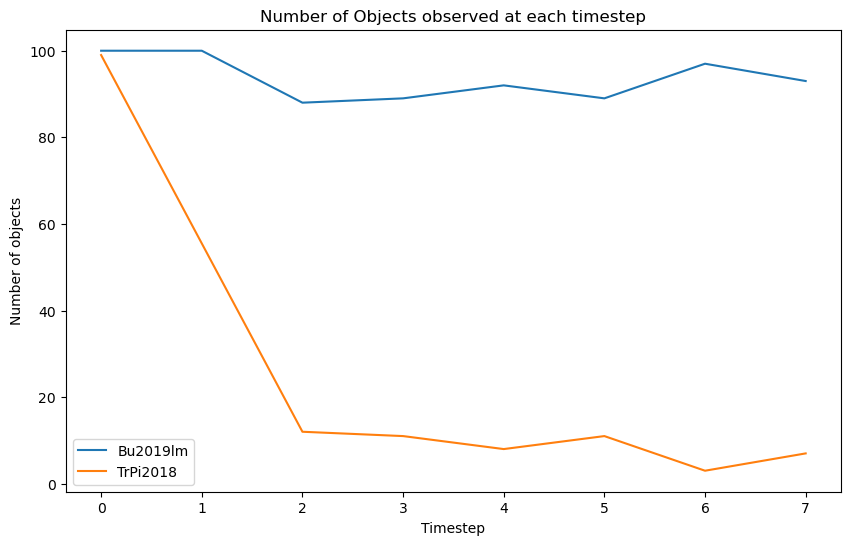

kilonova objects observed at each timestep
 0    100.0
1    100.0
2     88.0
3     89.0
4     92.0
5     89.0
6     97.0
7     93.0
Name: Timestep, dtype: float64
average kilonova selection rate at all timesteps
 0.9257142857142857


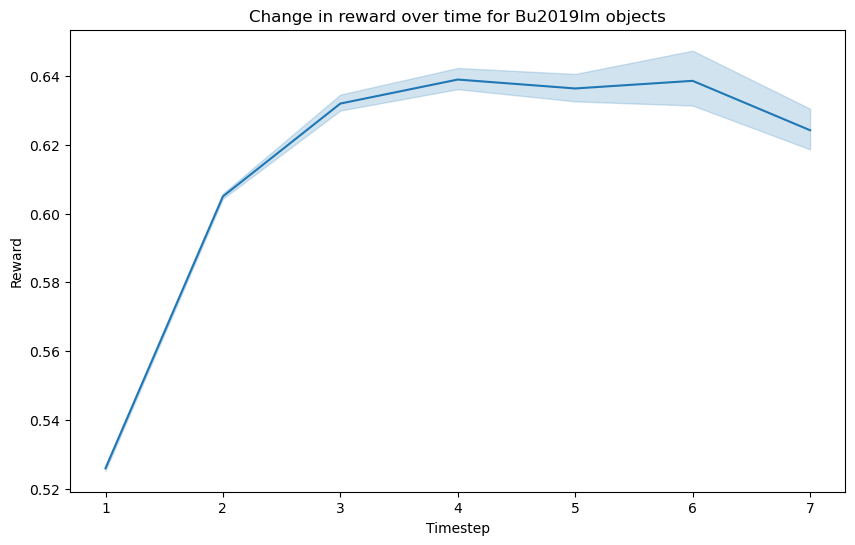

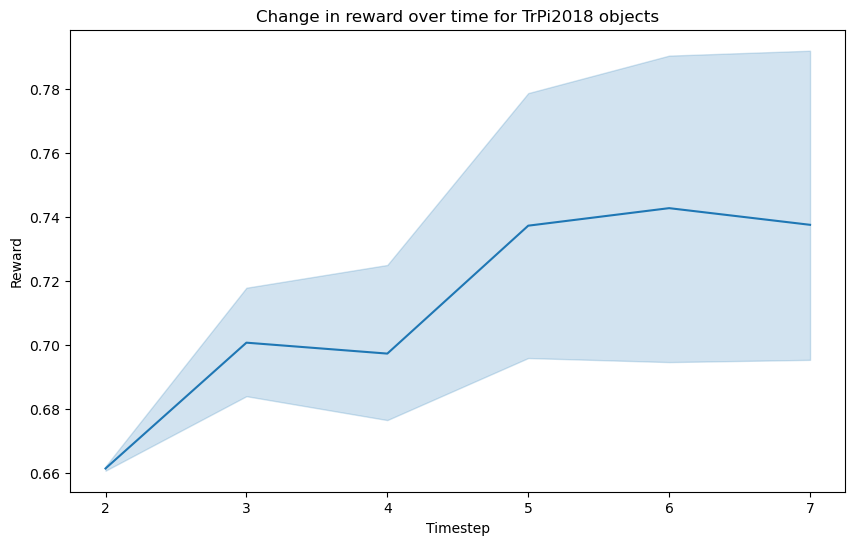

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the dataframe for Bu2019lm objects
bu2019lm_df = df[df['Object'].str.contains('Bu2019lm')]

# Count the number of Bu2019lm objects observed at each timestep
bu2019lm_counts = bu2019lm_df['Timestep'].value_counts().sort_index()

# Filter the dataframe for TrPi2018 objects
trpi2018_df = df[df['Object'].str.contains('TrPi2018')]

# Count the number of TrPi2018 objects observed at each timestep
trpi2018_counts = trpi2018_df['Timestep'].value_counts().sort_index()

# Filter the dataframe for nugent-hyper objects
nugent_hyper_df = df[df['Object'].str.contains('nugent-hyper')]

# Count the number of nugent-hyper objects observed at each timestep
nugent_hyper_counts = nugent_hyper_df['Timestep'].value_counts().sort_index()

# Plot the number of Bu2019lm, TrPi2018, and nugent-hyper objects observed at each timestep
plt.figure(figsize=(10, 6))
sns.lineplot(x=bu2019lm_counts.index, y=bu2019lm_counts.values/3, label='Bu2019lm')
sns.lineplot(x=trpi2018_counts.index, y=trpi2018_counts.values/3, label='TrPi2018')
# sns.lineplot(x=nugent_hyper_counts.index, y=nugent_hyper_counts.values/3, label='nugent-hyper')
plt.xlabel('Timestep')
plt.ylabel('Number of objects')
plt.title('Number of Objects observed at each timestep')
plt.legend()
plt.show()
## also print the number of kilonova/Bu2019lm objects observed at each time step
print('kilonova objects observed at each timestep\n', bu2019lm_counts/3)
print('average kilonova selection rate at all timesteps\n', (bu2019lm_counts.sum()-300)/3 / (700))


# Create new dataframes for plotting that exclude timestep 0
bu2019lm_df_plot = bu2019lm_df[bu2019lm_df['Timestep'] != 0]
trpi2018_df_plot = trpi2018_df[trpi2018_df['Timestep'] != 0]
nugent_hyper_df_plot = nugent_hyper_df[nugent_hyper_df['Timestep'] != 0]

# Plot the change in reward over time for Bu2019lm objects
plt.figure(figsize=(10, 6))
sns.lineplot(x=bu2019lm_df_plot['Timestep'], y=bu2019lm_df_plot['Reward'])
plt.xlabel('Timestep')
plt.ylabel('Reward')
plt.title('Change in reward over time for Bu2019lm objects')
plt.show()

# Change in reward over time for TrPi2018 objects
plt.figure(figsize=(10, 6))
sns.lineplot(x=trpi2018_df_plot['Timestep'], y=trpi2018_df_plot['Reward'])
plt.xlabel('Timestep')
plt.ylabel('Reward')
plt.title('Change in reward over time for TrPi2018 objects')
plt.show()

# # Change in reward over time for nugent-hyper objects
# plt.figure(figsize=(10, 6))
# sns.lineplot(x=nugent_hyper_df_plot['Timestep'], y=nugent_hyper_df_plot['Reward'])
# plt.xlabel('Timestep')
# plt.ylabel('Reward')
# plt.title('Change in reward over time for nugent-hyper objects')
# plt.show()

In [31]:
import os
import json

inj_dict = {}
for root, dirs, files in os.walk('paperFits'):
    for file in files:
        if file.startswith('inj') and file.endswith('.json'):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                data = json.load(f)
                data = data['injections']['content']
                for key, value in data.items():
                    data[key] = value[0]
            key = file.replace('inj_', '').replace('.json', '')
            inj_dict[key] = data

In [15]:

## remove items if they include 'fit' in the name
# file_paths = [x for x in file_paths if 'fit' not in x]
# len(file_paths)

899


In [19]:
obs_lc_file_paths = glob.glob('paperFits/expanse/lustre/projects/umn131/tbarna/ztfevalPaper/Bu2019lm/*/observed_lc*json', recursive=True)
print(len(obs_lc_file_paths))

# Initialize an empty dictionary to store the data from the files
obs_lc_dict = {}

# Loop through the file paths

for file_path in obs_lc_file_paths:
    # Get the filename without the 'observed_lc_' and '.json' components
    filename = os.path.basename(file_path).replace('observed_lc_', '').replace('.json', '')
    # Open each file and load the JSON data from the file
    with open(file_path, 'r') as file:
        obs_lc_dict[filename] = json.load(file)
    # Clear the file data from memory
    file.close()
    del file

899


In [20]:
obs_lc_dict

{'nugent-hyper_00712': {'ztfg': [[0.0,
    15.831767781166404,
    0.011469290469964486],
   [0.0, 15.831767781166404, 0.011469290469964486],
   [1.9674397891649278, 15.21269293412509, 0.015188563980831113],
   [3.954194238431228, 14.761841457113881, 0.032495303025677415]]},
 'nugent-hyper_00710': {'ztfg': [[0.0,
    15.789076273965138,
    0.011469290469964486],
   [0.0, 15.789076273965138, 0.011469290469964486],
   [1.9674397891649278, 15.170260932481032, 0.015188563980831113],
   [3.954194238431228, 14.71888213879965, 0.032495303025677415]]},
 'Bu2019lm_00710': {'ztfg': [[0.0, 12.248294969178817, 0.011469290469964486],
   [0.0, 12.248294969178817, 0.011469290469964486],
   [1.9674397891649278, 13.985199816307507, 0.015188563980831113],
   [3.954194238431228, 14.950930044487713, 0.032495303025677415],
   [3.954194238431228, 14.950930044487713, 0.032495303025677415],
   [5.93396047927672, 15.75676172968077, 0.007328199100936812],
   [8.929190734575968, 17.343986201008388, 0.0064530228